# Predicting who would survive the _Titanic_ disaster

In this activity, you'll develop a small machine learning model to make predictions. The data we'll use comes from the [_Titanic_ disaster of 1912](https://en.wikipedia.org/wiki/Titanic). The [_Titanic_ passengers dataset](https://www.openml.org/search?type=data&sort=runs&id=40945&status=active) has details of just over 1,000 passengers on the ship, including whether they lived or died.

We'll use this data to predict what would happen to the two stars of the [1997 film _Titanic_](https://en.wikipedia.org/wiki/Titanic_(1997_film)).

On the way, you'll learn some key concepts behind machine learning.

First, we'll load some libraries to process the data, and load the dataset. We've done some pre-processing on the data to convert it to a form that's suitable for the machine learning process we'll be using here.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
!wget --no-check-certificate https://raw.githubusercontent.com/NeilNjae/nominet-quick-start-ai/main/1.titanic-survivors/titanic.csv

--2025-08-28 15:17:27--  https://raw.githubusercontent.com/NeilNjae/nominet-quick-start-ai/main/1.titanic-survivors/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53378 (52K) [text/plain]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  52.13K  --.-KB/s    in 0.01s   

2025-08-28 15:17:27 (4.57 MB/s) - ‘titanic.csv’ saved [53378/53378]



In [3]:
titanic_data = pd.read_csv('titanic.csv')
titanic_data

,survived,passenger_class,age,siblings_spouses,parents_children,fare,has_cabin,is_female,embarked_C,embarked_Q,embarked_S
0,True,1,29.0000,0,0,211.3375,True,True,False,False,True
1,True,1,0.9167,1,2,151.5500,True,False,False,False,True
2,False,1,2.0000,1,2,151.5500,True,True,False,False,True
3,False,1,30.0000,1,2,151.5500,True,False,False,False,True
4,False,1,25.0000,1,2,151.5500,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
1038,False,3,45.5000,0,0,7.2250,False,False,True,False,False
1039,False,3,14.5000,1,0,14.4542,False,True,True,False,False
1040,False,3,26.5000,0,0,7.2250,False,False,True,False,False
1041,False,3,27.0000,0,0,7.2250,False,False,True,False,False


The data has one row for each passenger. The columns show the different data recorded for each passenger. The meanings of the columns are:

| Column | Meaning |
|--------|---------|
| passenger_class | Class of ticket |
| age | Passenger's age |
| siblings_spouses | Number of siblings and/or spouses aboard |
| parents_children | Number of parents and/or children aboard |
| fare | Amount paid for the ticket |
| has_cabin | Whether the passenger had a cabin |
| is_female | Whether the passenger is female |
| embarked_C | Where the passenger embarked: |
| embarked_Q | Southampton, Cherbourg, or Queenstown |
| embarked_S |  |

# Looking at the data

Now we have the data, we can plot a few graphs to understand who did or didn't survive the _Titanic_ disaster.

The first question is, how many people were aboard? How were they distributed by class and gender?

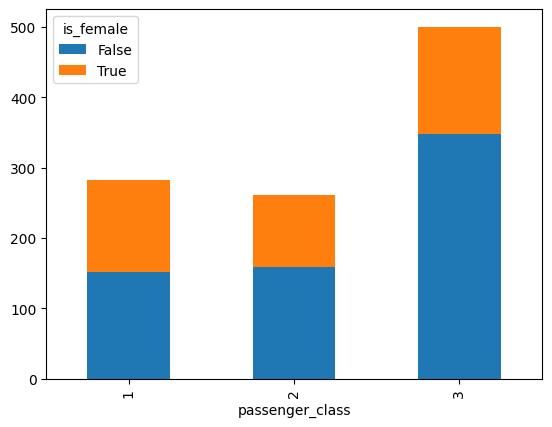

In [4]:
titanic_data[['passenger_class', 'is_female']].value_counts().sort_index().unstack().plot.bar(stacked=True);

This shows that there were roughly equal numbers of first and second class passengers, and about twice that for third class. It also shows that first class was about half women, second class had a few more men than women, but third class was over two-thirds men.

The _Titanic_ disaster is reputed for the claim of "women and children first!" The idea is that women and children were given priority when getting in the limited number of lifeboats. If that is the case, we should see women and children surviving at a higher rate than men.

We can see if that's true by plotting the number of survivors and casualties, split by gender.

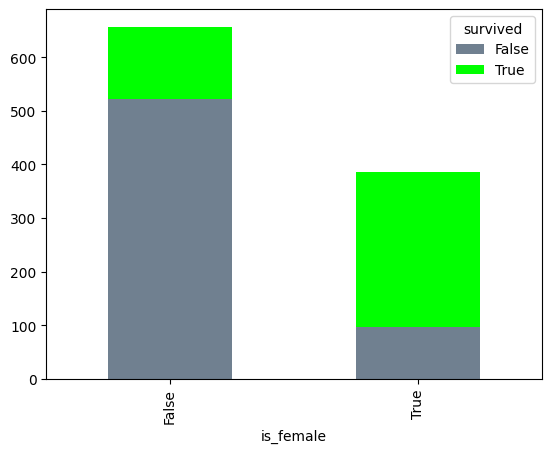

In [5]:
titanic_data[['is_female', 'survived']].value_counts().sort_index().unstack().plot.bar(stacked=True, color=['slategray', 'lime']);

This clearly shows that a much greater proportion of women survived than men.

We can also ask about whether children survived. To make the plot clearer, we group the passengers into bands of ten years each; the labels show the "tens" digit of their ages. Again, we plot how many in each age band survived.

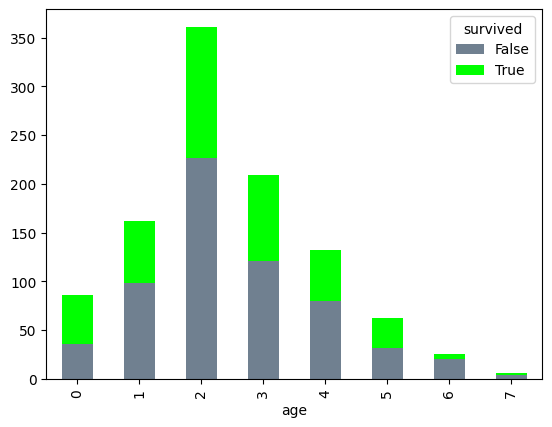

In [6]:
t = pd.concat([pd.cut(titanic_data.age, bins=8, labels=list(range(8))), titanic_data.survived], axis='columns')
t = t.value_counts().sort_index().unstack().fillna(0)
t.plot.bar(stacked=True, color=['slategray', 'lime']);

The numbers in each age band are very different, so it's hard to draw conclusions. Let's scale the bars so they're all the same height, and we can directly see the proportions.

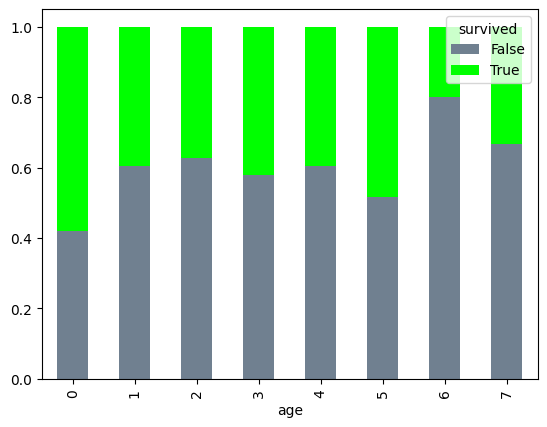

In [7]:
t = t.div(t.sum(axis='columns'), axis='rows')
t.plot.bar(stacked=True, color=['slategray', 'lime']);

This shows that children did have a higher survival rate than others, but it wasn't a huge difference.

Another element to look at is the class of the passengers. Was the _Titanic_ disaster one where "rank hath its priviliges" and the better-off passengers were more likely to survive?

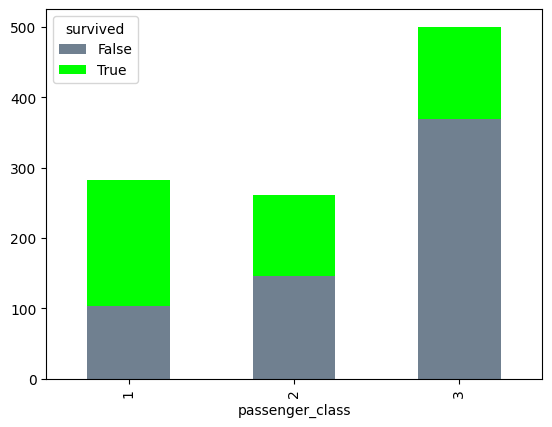

In [8]:
titanic_data[['passenger_class', 'survived']].value_counts().sort_index().unstack().plot.bar(stacked=True, color=['slategray', 'lime']);

There's a clear difference among the classes, with a much higher proportion of first class passengers surviving than other classes, and most of the third-class passengers dying.

We can also look at the combination of class and gender. Did the "women and children first" approach apply differently in different classes?

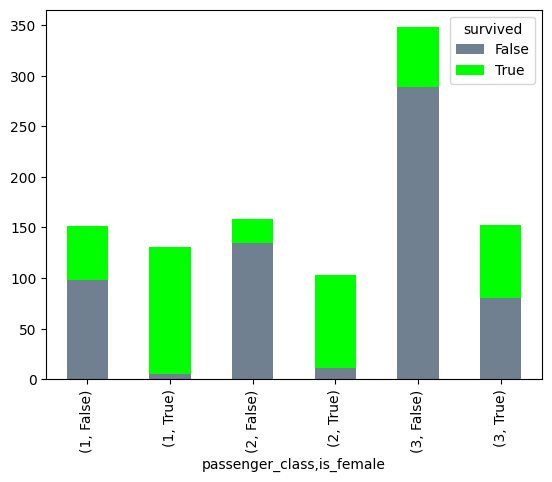

In [9]:
titanic_data[['passenger_class', 'is_female', 'survived']].value_counts().sort_index().unstack().plot.bar(stacked=True, color=['slategray', 'lime']);

The evidence suggests that yes, it did, but in all classes the women had a higher survivial rate than the men. The difference is most stark among the second-class passengers, where most of the men died but most of the women survived.

# Machine learning

Looking at some overviews of the data can help us understand some parts of the human cost of the disaster, but they can only go so far. Another approach is to use machine learning to understand the fates of people on the _Titanic_.

In this activity we'll use a _decision tree_. This is like a game of _Twenty Questions_ or some bird identification keys. When you're trying to classify some item, you ask a series of yes/no questions. Based on the answers, you move down the tree to the next question. When you reach a leaf of the tree, you have your answer.

For instance, consider this simple decision tree, about whether it's worth going outside to play tennis.

![A decision tree](https://github.com/NeilNjae/nominet-quick-start-ai/blob/main/1.titanic-survivors/GEP_decision_tree_with_numeric_and_nominal_attributes.png?raw=1)

When it comes to learning a decision tree, we start with some data, labelled with its true classification. For instance, with the _Titanic_ data, a very _very_ simple model assumes that everyone on the ship died. This model has an accuracy of 59%: 59% of passengers did indeed die.

We then look at ways we could split the data, based on the values of some of the information we have. For instance, we could split the data based on gender. If we do that, we find that there are 386 women, of whom 290 (75%) survived, while there are 657 men of whom 135 (21%) survived. Therefore, we have a simple decision tree that asks "is this person female?"; if yes, we predict they survived; if no, we predict they died. When we combine these cases, we get a model that has an overall accuracy of 78%. The tree is shown below; the numbers in brackets show the number of people who died and survived respectively.

![Sample decision tree based on gender](https://github.com/NeilNjae/nominet-quick-start-ai/blob/main/1.titanic-survivors/small-decision-tree-female.webp?raw=1)

A different question we could ask would be whether a person is accompanied by any parents and/or children. 765 people have no parents or children aboard; of these, 268 (35%) survived. 278 people have are accompanied by at least one parent or child; of these, 157 (56%) survived. If we use this question to determine our prediction, we should predict that the unaccompanied people died and the accompanied survived. This model has an overall accuracy of 62%, only marginally better than just saying everyone died. Again, this tree is below.

![Sample decision tree based on group](https://github.com/NeilNjae/nominet-quick-start-ai/blob/main/1.titanic-survivors/small-decision-tree-alone.webp?raw=1)

Based on this analysis, the root node of our decision tree should select on gender. We can then apply the same procedure again on each of the sub-nodes we've created. We can pick a feature to choose between the women who survived and those who didn't, and the same for the men. We continue to grow the tree, splitting leaf nodes, until either all the people at that leaf are in the same category, there's nothing left to split them, or we reach some kind of limit to growing the tree.

(The technical details of how exactly to choose a feature to split on are a bit more involved than this, but this is the essence of how the "Gini impurity" algorithm works. There are other ways of doing this, but we won't go into the details of them here.)

We now split the data into two parts: the information we're predicting, and the information we're using to make this prediction. By convention, we use the name _X_ for the information we're given and the name _y_ for the information to be predicted. We also convert the data from a Dataframe to a raw array, as is needed by the decision tree.

In [10]:
titanic_x = titanic_data.drop(['survived'], axis='columns').astype(float).values
titanic_y = titanic_data.survived.astype(float).values
titanic_x

array([[ 1.    , 29.    ,  0.    , ...,  0.    ,  0.    ,  1.    ],
       [ 1.    ,  0.9167,  1.    , ...,  0.    ,  0.    ,  1.    ],
       [ 1.    ,  2.    ,  1.    , ...,  0.    ,  0.    ,  1.    ],
       ...,
       [ 3.    , 26.5   ,  0.    , ...,  1.    ,  0.    ,  0.    ],
       [ 3.    , 27.    ,  0.    , ...,  1.    ,  0.    ,  0.    ],
       [ 3.    , 29.    ,  0.    , ...,  0.    ,  0.    ,  1.    ]])

In [11]:
titanic_y

array([1., 1., 0., ..., 0., 0., 0.])

The final data preparation step is to split the data into training and testing data. (You'll see why this is important in a moment.) We reserve 20% of the data for testing, and use the rest for training. The testing data is selected randomly.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(titanic_x, titanic_y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((834, 10), (834,), (209, 10), (209,))

# Our first decision tree

Let's create a decision tree, and train it ("fit" it) on the data we provide.

In [13]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

How well does this work? We'll take the tree's accuracy score based on how well it predicts the actual outcomes.

In [14]:
decision_tree.score(X_train, y_train)

0.9808153477218226

I can't say exactly what your tree's score will be, as it depends on exactly which passenger records went into training and testing data (allocated randomly, remember?). But you should see someing like 98% accuracy.

How well does this decision tree work on the test data?

In [15]:
decision_tree.score(X_test, y_test)

0.7607655502392344

Again, your results will depend on the precise selection of testing data. But you'll probably see a much worse performance of around 72%.

Why this big difference?

## Examining the tree

If we ask a couple of questions about the tree, we might get some idea. How many levels is the tree, and how many leaf (terminal) nodes does it have?

In [16]:
decision_tree.get_depth()

21

In [17]:
decision_tree.get_n_leaves()

np.int64(208)

You'll see a depth of about 21 and about 200 leaves. And there are 834 records in the training data. That means that each leaf, where the classification gets made, only represents about four passengers.

We can also ask the decision tree to explain how it comes to a particular decision, by following the nodes being used to make the final classification. In the "play tennis" example above, we could "windy" node, then the "outlook" node, then the "humidity" one. That gives some kind of explanation for how the decision tree came to the decision it did.

First, we need to ask the tree to make predictions about the passengers in the test data.

In [18]:
y_pred = decision_tree.predict(X_test)

This chunk of code looks at the tree and prints the details in a human-sensible form. Don't worry about the details of it.

In [19]:
n_nodes = decision_tree.tree_.node_count
children_left = decision_tree.tree_.children_left
children_right = decision_tree.tree_.children_right
feature = decision_tree.tree_.feature
threshold = decision_tree.tree_.threshold

node_indicator = decision_tree.decision_path(X_test)
leaf_id = decision_tree.apply(X_test)

column_names = list(titanic_data.drop(['survived'], axis='columns').columns)

def show_prediction_path(sample_id):

    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]

    print((f"Rules used to predict sample {sample_id} "
           f"(actual class {y_test[sample_id]}, predicted class {y_pred[sample_id]}):\n"))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue

        # check if value of the split feature for sample 0 is below threshold
        if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            (f"decision node {node_id} : (X_test[{sample_id}, {feature[node_id]}] = "
             f"{X_test[sample_id, feature[node_id]]:2.2f}) "
             f"{threshold_sign} {threshold[node_id]:2.2f}) "
             f"({column_names[feature[node_id]]})")
            )

We can now ask the tree to explain its decision about a particular element of the test data. Let's pick out one particular example, element 10 of the test data. This is the information we have on that person.

In [20]:
list(zip(column_names, X_test[10]))

[('passenger_class', np.float64(2.0)),
 ('age', np.float64(39.0)),
 ('siblings_spouses', np.float64(0.0)),
 ('parents_children', np.float64(0.0)),
 ('fare', np.float64(26.0)),
 ('has_cabin', np.float64(0.0)),
 ('is_female', np.float64(0.0)),
 ('embarked_C', np.float64(0.0)),
 ('embarked_Q', np.float64(0.0)),
 ('embarked_S', np.float64(1.0))]

What decision was made about this person? How was this decison made?

In [21]:
show_prediction_path(10)

Rules used to predict sample 10 (actual class 0.0, predicted class 0.0):

decision node 0 : (X_test[10, 6] = 0.00) <= 0.50) (is_female)
decision node 1 : (X_test[10, 1] = 39.00) > 14.25) (age)
decision node 19 : (X_test[10, 5] = 0.00) <= 0.50) (has_cabin)
decision node 20 : (X_test[10, 7] = 0.00) <= 0.50) (embarked_C)
decision node 21 : (X_test[10, 4] = 26.00) > 7.81) (fare)
decision node 65 : (X_test[10, 4] = 26.00) <= 54.25) (fare)
decision node 66 : (X_test[10, 2] = 0.00) <= 2.50) (siblings_spouses)
decision node 67 : (X_test[10, 4] = 26.00) > 7.91) (fare)
decision node 75 : (X_test[10, 4] = 26.00) > 7.99) (fare)
decision node 85 : (X_test[10, 0] = 2.00) > 1.50) (passenger_class)
decision node 97 : (X_test[10, 1] = 39.00) <= 61.50) (age)
decision node 98 : (X_test[10, 4] = 26.00) > 11.00) (fare)
decision node 128 : (X_test[10, 1] = 39.00) > 25.50) (age)
decision node 130 : (X_test[10, 4] = 26.00) <= 28.45) (fare)
decision node 131 : (X_test[10, 4] = 26.00) > 18.96) (fare)


I can't predict the exact details of the questions, but you'll probably see lots of testing of age and fare, all seemingly doing much the same thing.

## Why it's going wrong: overfitting

All this means that the decision tree is **overfitting** to the training data. It's learnt _all_ the fine details of the training data, even the irrelevant ones, in an attempt to produce a good fit. But unseen data will have different irrelevant data, and that will fool the model into making the wrong predicitons.

The diagram below gives the idea. The model learns to separate the red and blue points, and essentially draws the wiggly green line to do so. Then the model is used to classify the black-bordered points, and the overly-wiggly green line gets a lot of them wrong. If the model had been constrained to produce a simpler line of separation (the black line), the performance on the training data would be lower, but the performance on new data would be be much better.

![Overfitting example](https://github.com/NeilNjae/nominet-quick-start-ai/blob/main/1.titanic-survivors/overfitting.png?raw=1)

How do we constrain the complexity of a decision tree model? There are a few ways, but the simplest is to limit the depth of the tree. There are probably only a few key variables in the data that determine survival or not, and the rest are just noise or irrelevant detail (such as the precise cost of a ticket).

We can limit the depth of a decision tree by passing in the `max_depth` parameter when we create it. Let's try a depth of 1, as per the example diagrams above.

In [22]:
decision_tree = tree.DecisionTreeClassifier(max_depth=1)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

How well does this work? Again, we'll score the tree on both the training and testing data.

In [23]:
decision_tree.score(X_train, y_train)

0.7781774580335732

In [24]:
decision_tree.score(X_test, y_test)

0.7799043062200957

Again, your results will depend on the precise selection of testing data. But you'll probably see a much worse performance of around 76%, and very little difference between the training and testing results.

This tree is also small enough to show its full structure.

Each node in the decision tree contains some information about itself:
* a node number, as an identifier
* the test made at this node
* the number of elements (passengers) in the training data that are processed by this node
* the balance of classes of elements (passenger) at this node. The first number is the number of passengers who died, the second is the number of passengers who survived.

In the sample image below, the test at `node #0` is whether the `is_female` feature is less than 0.5 (in other words, `is_female` is false). 521 elements of the training data end up in `node #1`; 414 of those people died, 107 survived.

![A sample tree](https://github.com/NeilNjae/nominet-quick-start-ai/blob/main/1.titanic-survivors/sample_shallow_tree.png?raw=1)

The cell below will show your own tree. It will look a little different from this sample.

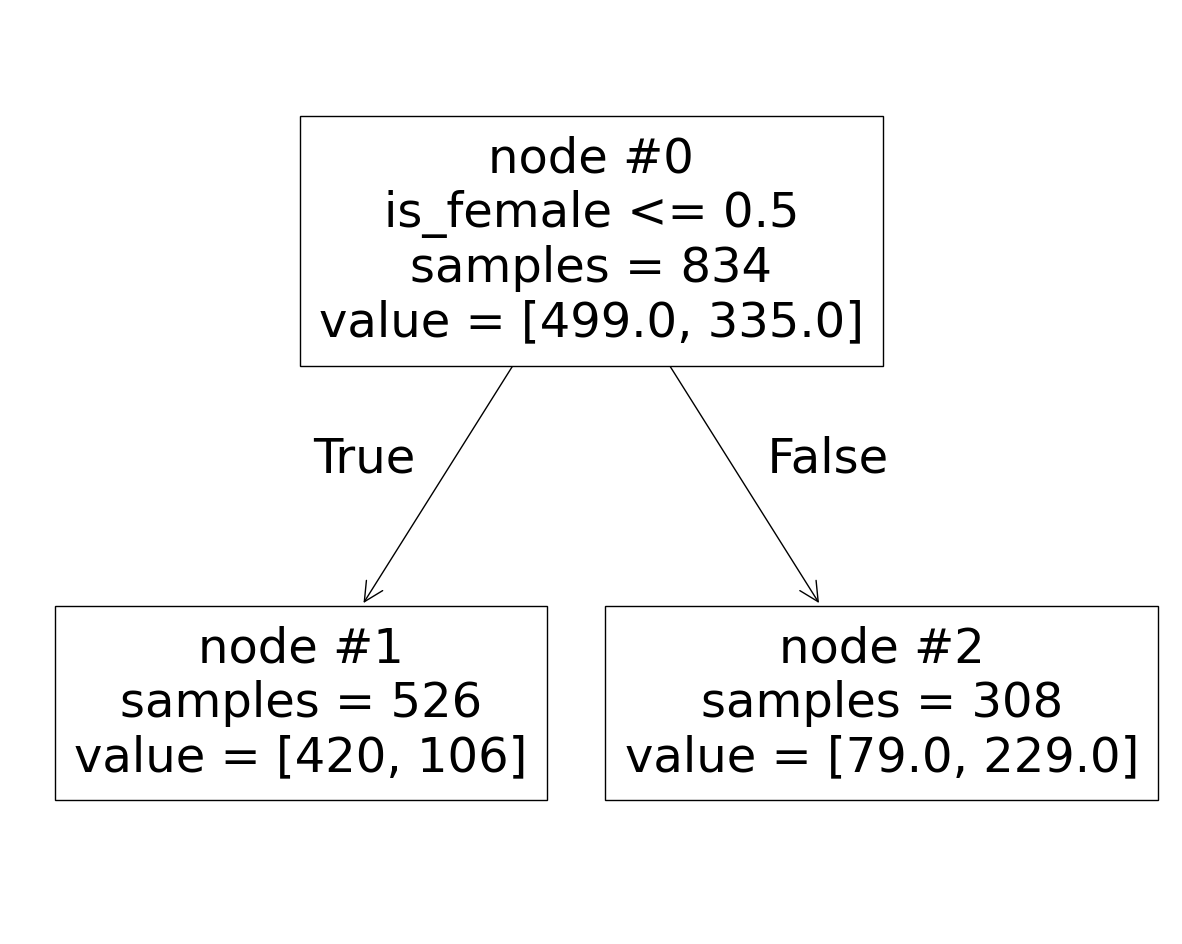

In [25]:
plt.figure(figsize=(15, 12))
f = tree.plot_tree(decision_tree,
              feature_names=column_names,
              node_ids=True,
              impurity=False,
              );

# Finding a better tree depth

A depth of 1 is too little. A depth of 21-ish is too much. What's the best depth, that balances how the tree takes into account the data, and getting distracted by irrelevant noise? Unfortunately, there's no hard-and-fast rule to tell you what the best depth may be. You could make guesses based on the type of data, or you could try a few depths and see what works best.

You don't know enough to make guesses based on the data, so trial-and-error it is.

The obvious way to do this is to train a series of trees on the training data, then evaluate them on the testing data. But that's a problem because we're "marking our own homework". As we're including the testing data in the process for how to find the best model, we've nothing left to see how the model works on truely unseen data.

What we need to do is split our training data into two parts. Most of it we'll use for training; some we'll reserve for _validation_ of the models as we're building them. Once we're happy with the model we want to use, we'll see how well it _really_ does on genuinely unseen data.

In [26]:
X_train_small, X_validation, y_train_small, y_validation = train_test_split(X_train, y_train, test_size=0.2)
X_train_small.shape, y_train_small.shape, X_validation.shape, y_validation.shape

((667, 10), (667,), (167, 10), (167,))

In [27]:
depth_scores = pd.Series()
for depth in range(1, 20):
    decision_tree = tree.DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train_small, y_train_small)
    score = decision_tree.score(X_validation, y_validation)
    depth_scores[depth] = score
depth_scores

,0
1,0.742515
2,0.802395
3,0.772455
4,0.814371
5,0.808383
6,0.808383
7,0.778443
8,0.748503
9,0.748503
10,0.730539


<Axes: >

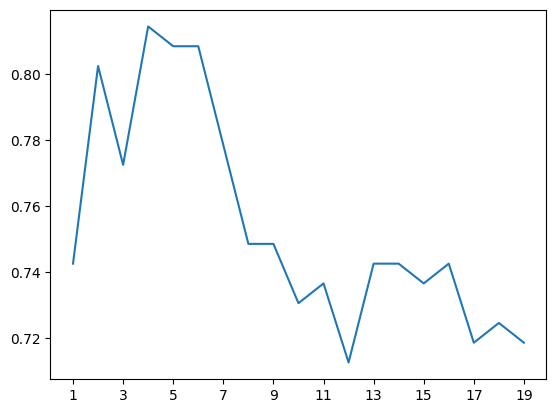

In [28]:
depth_scores.plot(xticks=(list(range(1, 20, 2))))

Your results will vary here, but you'll probably find that a tree depth of 3 gives the best result on your validation data.

Let's use that to generate the tree we will use. Now we know the best depth, we can train the tree on all the data.

In [29]:
decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

How well does it work?

In [30]:
decision_tree.score(X_test, y_test)

0.8038277511961722

What does this tree look like? Refer to the sample above to interpret the values shown in the nodes.

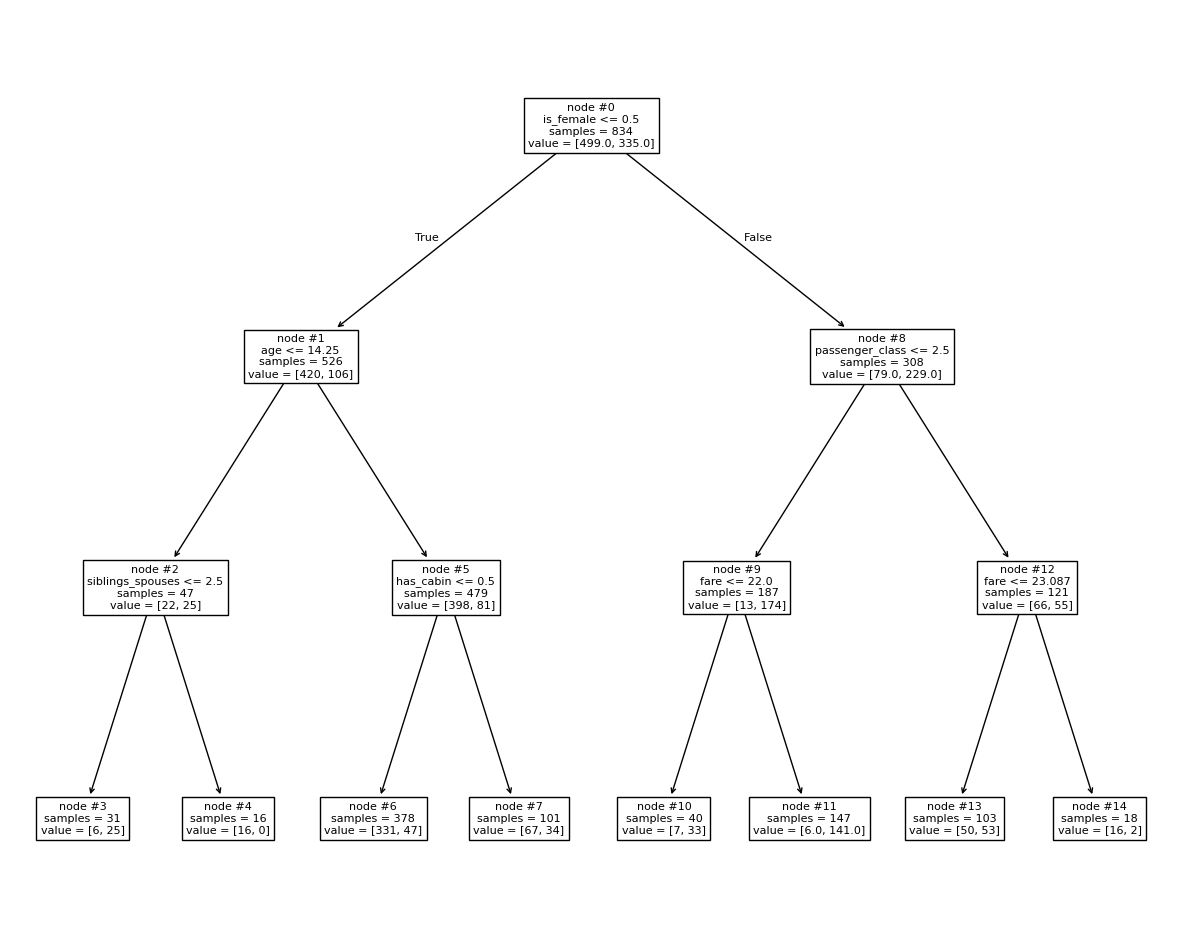

In [31]:
plt.figure(figsize=(15, 12))
tree.plot_tree(decision_tree,
              feature_names=column_names,
              node_ids=True,
              impurity=False,
              );

We re-capture the details of the tree to generate explanations for how the tree classifies the test data. That also means we generate new predictions for the test data.

In [32]:
y_pred = decision_tree.predict(X_test)

In [33]:
n_nodes = decision_tree.tree_.node_count
children_left = decision_tree.tree_.children_left
children_right = decision_tree.tree_.children_right
feature = decision_tree.tree_.feature
threshold = decision_tree.tree_.threshold

node_indicator = decision_tree.decision_path(X_test)
leaf_id = decision_tree.apply(X_test)

And we can look at how one particular node is classified.

In [34]:
sample_passenger_id = 3
print(list(zip(column_names, X_test[sample_passenger_id])))
show_prediction_path(sample_passenger_id)

[('passenger_class', np.float64(3.0)), ('age', np.float64(28.0)), ('siblings_spouses', np.float64(0.0)), ('parents_children', np.float64(0.0)), ('fare', np.float64(9.5)), ('has_cabin', np.float64(0.0)), ('is_female', np.float64(0.0)), ('embarked_C', np.float64(0.0)), ('embarked_Q', np.float64(0.0)), ('embarked_S', np.float64(1.0))]
Rules used to predict sample 3 (actual class 0.0, predicted class 0.0):

decision node 0 : (X_test[3, 6] = 0.00) <= 0.50) (is_female)
decision node 1 : (X_test[3, 1] = 28.00) > 14.25) (age)
decision node 5 : (X_test[3, 5] = 0.00) <= 0.50) (has_cabin)


If you compare this to the first decision tree, you should find that the explanation for the classification is easier to understand and makes a little more sense why each question is asked.

# Predicting Rose and Jack
Rose and Jack are the two lead chacters from the film _Titanic_. Rose is a young upper-class woman, Jack is a young lower-class man. In the film, Rose survived the shipwreck but Jack did not.

This is the data that represents these fictional characters.

In [35]:
rose_jack = pd.DataFrame([{'survived': True, 'passenger_class': 1, 'age': 17, 'siblings_spouses': 0, 'parents_children': 1, 'fare': 200,
                          'has_cabin': True, 'is_female': True, 'embarked_C': False, 'embarked_Q': False, 'embarked_S': True},
                         {'survived': False, 'passenger_class': 3, 'age': 20, 'siblings_spouses': 0, 'parents_children': 0, 'fare': 10,
                          'has_cabin': False, 'is_female': False, 'embarked_C': False, 'embarked_Q': False, 'embarked_S': True}])
rose_jack

,survived,passenger_class,age,siblings_spouses,parents_children,fare,has_cabin,is_female,embarked_C,embarked_Q,embarked_S
0,True,1,17,0,1,200,True,True,False,False,True
1,False,3,20,0,0,10,False,False,False,False,True


We can convert this into the form that the decision tree expects.

In [36]:
X_rose_jack = rose_jack.drop(['survived'], axis='columns').astype(float).values
y_rose_jack = rose_jack.survived.astype(float).values

Now we can ask the tree to predict the fates of Rose and Jack.

In [37]:
decision_tree.predict(X_rose_jack)

array([1., 0.])

The results will depend on your tree, but you should see the result

```python
array([1., 0.])
```

meaning the first record (Rose) is predicted to survive (class 1), while the second (Jack) is predicted to die (class 0). These are the correct classifications.

We can ask this tree for its accuracy `score` on "Rose and Jack" as a whole.

In [38]:
decision_tree.score(X_rose_jack, y_rose_jack)

1.0

You probably see a score of 1.0, meaning 100%.

# Conclusions

This has been a quick introduction to machine learning, using decision trees to predict survival after the _Titanic_ disaster. You've learnt a few things from this activity.

* Machine learning relies on good data to train models.
* We need to reserve some of this data as unseen _testing_ data to check how well our models will do on new data.
* A signficiant problem with machine learning is _overfitting_, where the machine learning model learns too much from the detail of the training data.
* We can address overfitting by keeping the models simple and validating models against data that isn't used for training.